# Ch5. 합성곱 신경망(Convolution Neural Network) 

## 5.2 합성곱의 연산 과정

filter ( kernel이라 부릅니다)를 움직여가며 곱->합->평균으로 다음 셀에 넘김

필터의 이동 단위 : Stride

필터당 입력 이미지 전체에 대한 일치 정도를 활성화지도( activation map, feature map )

feature map의 크기 $ O = floor \left( \frac{I - K}{S} + 1 \right) $ with 이미지 크기 $ I $, 필터 크기 $K$, 스트라이드 $ S $

활성화 함수 ReLU, ricky ReLU, randomized ricky ReLU 에 대한 설명이 있었어요

## 5.3 패딩과 풀링 (Padding and pooling)

패딩 : feture map의 크기와 원 이미지의 크기를 일치시키기 위해 바깥쪽에 넣는 임의 값, 이미지가 충분히 크다면 굳이 필요 x

 $ O = floor \left( \frac{I - K + 2P }{S} + 1 \right) $ with 이미지 크기 $ I $, 필터 크기 $K$, 패딩 크기 $P$, 스트라이드 $ S $
 
풀링(Pooling = downsampling = subsampling) : 큰 이미지를 작게

Max Pooling or Avg Pooling

## 5.4 모델의 3차원적 이해

$ l \times m $ 의 이미지에 n개 필터를 적용하면 다음 레이어에서는 $ l \times m \times n $ 짜리 박스가 만들어진다는 관점

가로 세로는 풀링을 통해 줄어들고 필터 갯수에 따라 채널 수가 늘어나며

충분히 특성을 뽑아냈다고 판단되면 완전연결 레이어를 적용해서 가로 x 세로 x 채널의 하나의 벡터가 생성


## 5.5 softMax 함수

분류하려는 클래스 갯수에 따라 binary vector로 만드는 방법 : one-hot encoding

각 클래스에 대한 확률 값을 나타내는 함수 = softmax func

\begin{align}
softmax \left(y_i \right) = \frac{ exp( y_i ) }{ \sum_j{exp(y_j)}}
\end{align}

softmax 사용시 손실 측정 법 : cross entropy (교차 엔트로피)
\begin{align}
엔트로피 H \left( p \right) = - \sum_{x} {p \left( x \right) \log p \left( x \right) }
\end{align}
\begin{align}
교차 엔트로피 H \left( p, q \right) = - \sum_{x} {p \left( x \right) \log q \left( x \right) }
\end{align}

교차 엔트로피가 크다라는 것은 최적의 상태보다 더 많은 비트가 필요하다는 뜻 
\begin{align}
교차 엔트로피 H \left( p, q \right) = H \left( p \right) + \sum_{x} {p \left( x \right) \log \frac{p \left( x \right)} {q \left( x \right)} }
\end{align}
\begin{align}
\qquad \qquad \qquad = H \left( p \right) + D_{KL} \left( p \parallel q \right)
\end{align}

KLD(Kullback-Leibler divergence, 쿨러-라이블러 발산) 항 : 분포 p를 기준으로 q가 얼마나 다른지 측정하는 방법

KLD을 최소화하는 방향으로 학습. L1norm보다 더 손실에 민감함.



## 5.6 모델 구현, 학습 및 결과 확인 : MNIST example

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

#torchvision : 영상처리용 데이터셋, 모델, 이미지 변환기 등
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.utils.data import DataLoader 
#데이터를 하나씩 보내지 않고 batch size별로 전달하기 위해서 필요

batch_size = 256
learning_rate = 0.0002
num_epoch = 10

In [4]:
#MNIST : 28 * 28 숫자 이미지

mnist_train = dset.MNIST("./",train=True, transform=transforms.ToTensor(), target_transform = None, download=True)
mnist_test = dset.MNIST("./",train=False, transform=transforms.ToTensor(), target_transform = None, download=True)

#transform : 이미지에 대한 변형, target_tansform : 라벨에 대한 변형(그대로 쓸거임)
#다운로드는 현재 경로에 없을 경우 다운로드한다는 뜻

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2,drop_last=True)

#뱃치만큼 로드할거고 num_workers는 프로세스 개수 drop_last : 묶고 남는 데이터 버릴지


100%|███████████████████████████████████████████████████████████████████▊| 9887744/9912422 [00:47<00:00, 392990.67it/s]

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



0it [00:00, ?it/s]
 57%|█████████████████████████████████████████▍                               | 16384/28881 [00:00<00:00, 66240.81it/s]
32768it [00:00, 46736.13it/s]                                                                                          

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



0it [00:00, ?it/s]
 73%|█████████████████████████████████████████████████▎                  | 1196032/1648877 [00:07<00:01, 372595.74it/s]
9920512it [01:00, 392990.67it/s]                                                                                       
 97%|██████████████████████████████████████████████████████████████████▏ | 1605632/1648877 [00:11<00:00, 136452.99it/s]

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw




0it [00:00, ?it/s]

  0%|                                                                                         | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 18375.57it/s]                                                                                           

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw
Processing...
Done!



1654784it [00:30, 136452.99it/s]                                                                                       

In [12]:
print(mnist_train,"\n")
print(mnist_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor() 


Dataset MNIST
    Number of datapoints: 10000
    Root location: ./
    Split: Test
    StandardTransform
Transform: ToTensor()


In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,5), # in, out, kernel : mnist가 batch, 1, 28, 28이라 in은 1 out은 16, kernel은 임의로 5
            nn.ReLU(),
            nn.Conv2d(16,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2), #kernel, stride
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*3*3,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
        
    def forward(self,x):
        out = self.layer(x) # construct한 모델에 데이터를 넣은 결과
        out = out.view(batch_size,-1) # -1은 -1인 부분은 알아서 계산하라는 뜻
        out = self.fc_layer(out) # DNN으로 10개 class중 하나로
        return out

입력 텐서 : [batch_size, in_channels, 가로, 세로]

합성곱 연산 이후 : [batch_size, out_channels, 가로, 세로]

첫번째 Conv2d에서는 입력이 [batch, 1, 28, 28]이었고 $ O = floor \left( \frac{I-K+2P}{S} +1 \right) = floor \left( \frac{28-5+2 \times 0}{1} +1 \right) = 24 $. 따라서 출력은 [batch, 16, 24,24]. 비슷하게 이후엔 [batch, 32, 20, 20]

MaxPool을 통과한 이후엔 [batch, 32, 10, 10] 다시 Conv2d 통과하면 [batch, 64, 6, 6] MaxPool 통과하면 [batch, 64, 3, 3]

views는 텐서를 펼쳐서 보겠다는 함수

이후에 DNN으로 확률보기

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #adam 알고리즘으로 옵티마이즈

In [22]:
loss_arr=[]
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        loss_arr.append(loss.cpu().detach().numpy())
        
        if j%1000 == 0:
            print(loss)

tensor(2.3085, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.2516, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.1988, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0705, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0451, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0746, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0397, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0511, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0186, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.0251, device='cuda:0', grad_fn=<NllLossBackward>)


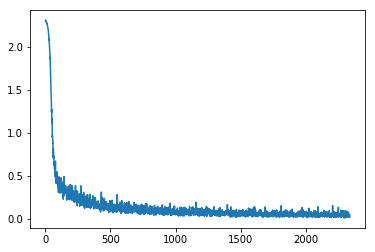

In [23]:
import matplotlib.pyplot as plt
plt.plot(loss_arr)
plt.show()

In [24]:
correct = 0
total = 0

with torch.no_grad(): #기울기를 계산하지 않는 조건에서
    for image,label in test_loader :
        x = image.to(device)
        y_= label.to(device)
        
        output = model.forward(x)
        _,output_index = torch.max(output,1) #최댓값과 그 인수 (언팩킹시 특정값 무시하고 싶으면 언더바 쓴대)
        
        total += label.size(0)
        correct += (output_index ==y_).sum().float()
        
    print("Accuracy of Test Data : {}".format(100*correct/total))

Accuracy of Test Data : 98.828125


## 5.7 유명한 모델들과 원리

### VGGNet

신경망의 깊이의 영향만을 파악하기 위해 Conv2D(3,3), Max Pooling, DNN 만을 사용해서 모델을 구성, 2014년 2위

11~19개 레이어로 실험을 진행.

https://arxiv.org/pdf/1409.1556.pdf

일반적으로 더 깊을 수록 정확도 올라감

자체구현시 미리 모델 일부를 함수로 짜놓으면 반복되는 부분을 줄일 수 있음

torchvision 공식 코드에서는 class에 \_\_init\_\_ , forward, initialize\_weights, make\_layers 함수를 구현해두고 각 레이어의 필터 수 또는 맥스풀링 여부만 가져와서 layer 구성하는 방식으로 구성

### GoogleNet

2014년 1위, 인셉션 모듈이라는 블록을 쓰기 때문에 인셉션 네트워크라고도 불림

인셉션 모듈 : 이전 단계의 활성화 지도에서 다양한 필터($1\times1 , 3\times3 , 5\times5 $)로 Conv 

https://arxiv.org/pdf/1409.4842v1.pdf

$ 1\times1 $ Conv를 통해 차원감소를 더함 : 입력 채널과 결과 채널 간의 DNN이라고 할 수 있음

Conv 곱이 가로세로 어느 위치든 동일하게 적용되기 때문에 연산량을 줄여줌 

기존에 128 -> 256 에서 128 -> 32 -> 256으로 

또한 Training에서 보조 분류기 (모델 중간에 softmax output을 줘서)를 둬서 네트워크 중간의 정보 손실을 메꾸는 역할

### ResNet

2015년 1위. 네트워크가 일정 수준 이상의 깊이가 되면 오히려 얕은 모델보다 성능이 떨어짐을 발견

이 문제를 해결하기 위해 residual learning(잔차 학습)을 도입. 

특정 위치에서 입력이 들어왔을때 합성곱 연산을 통과한 결과와 입력으로 들어온 결과 두가지를 더해서 다음 레이어에 전달하는 것.

https://arxiv.org/pdf/1512.03385.pdf

입력의 단순한 특성과 합성곱 이후의 복잡한 특성 모두를 전달한다는 특성 : $ x_{n+1} = F(x_n) + x_n $ : 기울기도 1

$ 1\times1 $ Conv -> $ 3\times3 $ -> $ 1\times1 $ -> $+$ 이런 부분을 bottleneck block이라고 불렀음



### 그 외

GoogleNet + ResNet + batch Regularization = Inception v4

ResNet의 잔차 학습을 channel 방향으로 붙이고 연결을 좀더 dense하게한 DenseNet 등

